# Setup #

In [36]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import cv2
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

import os
import math

# Detection algorithm works with an NxN matrix
N = 32
#N is a power of 2

# Helper Functions #

In [37]:
def plot_image(img, title: str):
    plt.title(title)
    
    if img.shape[0] <= 32:
        plt.xticks(range(img.shape[0]))
        plt.yticks(range(img.shape[1]))
    
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

In [21]:
#Normalize -- squared amplitudes must sum to 1
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Image Preprocessing #

In [22]:
def read_this(image_file, gray_scale=False):
    image_src = cv2.imread(image_file)
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src

In [48]:
def enhance_contrast(image_path, with_plot=True, gray_scale=False):
    # equalizing image
    def equalize_this(image_file, with_plot=False, gray_scale=False):
        image_src = read_this(image_file=image_file, gray_scale=gray_scale)
        if not gray_scale:
            r_image, g_image, b_image = cv2.split(image_src)

            r_image_eq = cv2.equalizeHist(r_image)
            g_image_eq = cv2.equalizeHist(g_image)
            b_image_eq = cv2.equalizeHist(b_image)

            image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
            cmap_val = None
        else:
            image_eq = cv2.equalizeHist(image_src)
            cmap_val = 'gray'

        if with_plot:
            fig = plt.figure(figsize=(10, 20))

            ax1 = fig.add_subplot(2, 2, 1)
            ax1.axis("off")
            ax1.title.set_text('Original')
            ax2 = fig.add_subplot(2, 2, 2)
            ax2.axis("off")
            ax2.title.set_text("Equalized")

            ax1.imshow(image_src, cmap=cmap_val)
            ax2.imshow(image_eq, cmap=cmap_val)
            #return True
        return image_eq

    img_eq = equalize_this(image_file=image_path,with_plot=False,gray_scale=False)

    # grayscaling the image
    gray_img=cv2.cvtColor(img_eq,cv2.COLOR_BGR2GRAY)

    # calculating histograms
    hist=cv2.calcHist(gray_img,[0],None,[256],[0,256])

    # equalizing histograms
    gray_img_eqhist=cv2.equalizeHist(gray_img)
    hist=cv2.calcHist(gray_img_eqhist,[0],None,[256],[0,256])

    # thresholding
    th=80
    max_val=255

    # ret, o1 = cv2.threshold(gray_img_eqhist, th, max_val, cv2.THRESH_BINARY)
    ret, o2 = cv2.threshold(gray_img_eqhist, th, max_val, cv2.THRESH_BINARY_INV)
    # ret, o3 = cv2.threshold(gray_img_eqhist, th, max_val, cv2.THRESH_TOZERO)
    # ret, o4 = cv2.threshold(gray_img_eqhist, th, max_val, cv2.THRESH_TOZERO_INV)
    # ret, o5 = cv2.threshold(gray_img_eqhist, th, max_val, cv2.THRESH_TRUNC)
    # ret ,o6=  cv2.threshold(gray_img_eqhist, th, max_val,  cv2.THRESH_OTSU)

    return o2

In [49]:
#Input Processing to np array
img_path = '/Users/noahjamescooney/Documents/GitHub/Capybaras-Capstone-Project/test_images/squarecapybara.jpg'
img_raw = enhance_contrast(img_path,with_plot=False,gray_scale=False)

n, m = img_raw.shape
k = 1
#n, m, k = img_raw.shape
print('Raw Image info:', img_raw.shape)
print('Raw Image datatype:', img_raw.dtype)

if n != m:
    raise Exception("Image must be square")

if n % N != 0:
    raise Exception(f"Image cannot be converted to an {N} by {N} matrix")

# we need to "reduce" each sz X sz grid
# sz is size
sz = n // N


Raw Image info: (512, 512)
Raw Image datatype: uint8


# Gridding

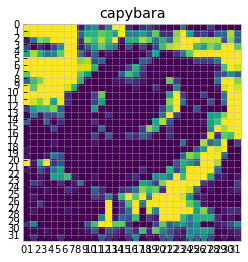

In [41]:
img = np.zeros(shape=(N, N))

for i in range(0, n, sz):
    for j in range(0, n, sz):
        val = 0
        #This will be a single cell in final pixel
        for k in range(0, sz):
            val += np.sum(img_raw[i + k][j:j+sz][0]) / 255
#             val += np.sum(img_raw[i + k][j:j+sz][1]) / 255
#             val += np.sum(img_raw[i + k][j:j+sz][2]) / 255
            
        img[i//sz][j//sz] = val

plot_image(img, "capybara")

In [42]:
# Horizontal: Original image
image_norm_h = amplitude_encode(img)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(img.T)

# Quantum Part (Simulation)

In [43]:
# qubit amount
# data_qb should be math.ceil(math.log2(N))
data_qb = math.ceil(math.log2(N**2))
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

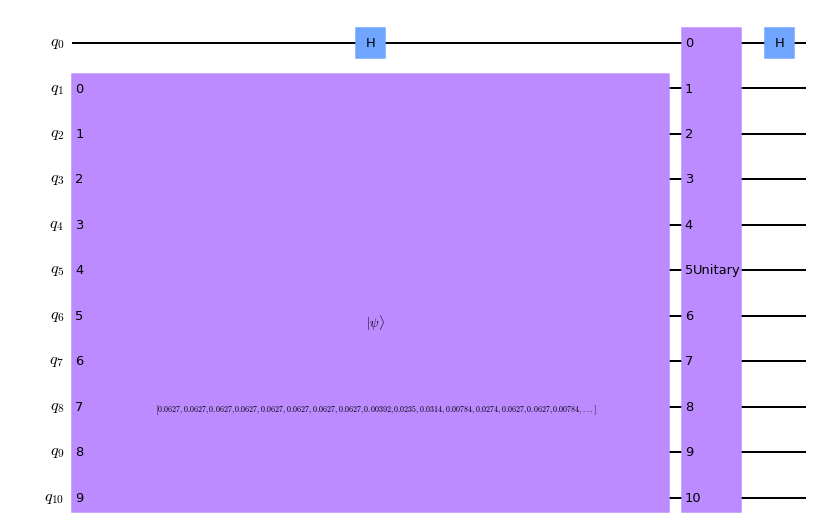

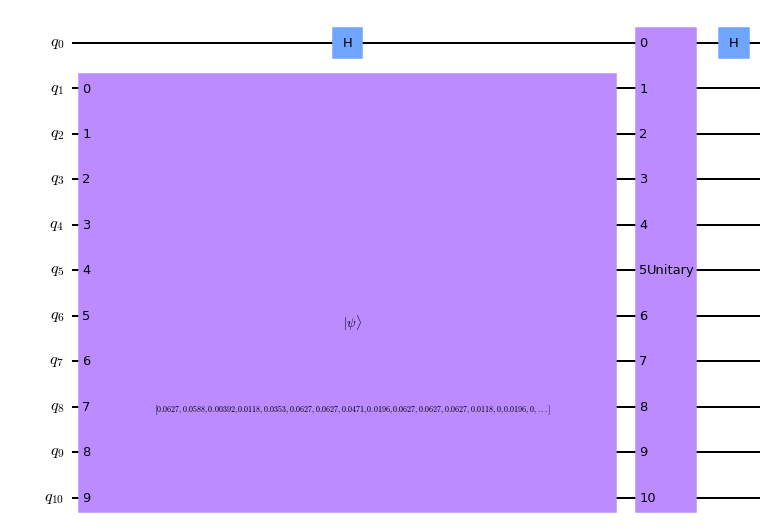

In [44]:
# horizontal scan circuit
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# vertical scan circuit
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits
circ_list = [qc_h, qc_v]

In [45]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

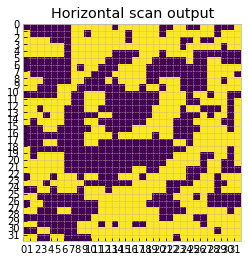

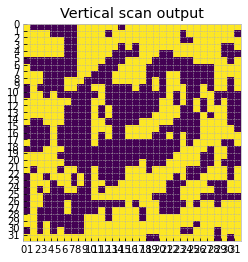

In [46]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

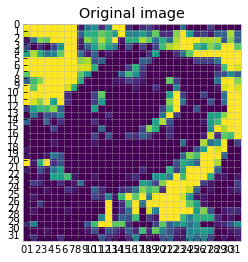

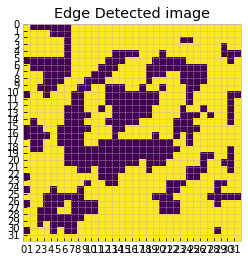

In [47]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(img, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')